# This file contains the necessary imports for Windows, MacOS, and Linux.

In [62]:
! bash imports.sh

# Imports from Gym, PyTorch, NumPy, and Matplotlib

In [6]:
import gym
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Create Batch of Episodes with max time of 5000 frames

In [10]:
def generate_batch(env,batch_size,time=5000):
    
    #activation layer
    activation = nn.Softmax(dim=1)

    #initial lists
    batch_actions =[]
    batch_states = []
    batch_rewards = []

    #iterate through batches
    for b in range(batch_size):

        #lists for each episode and reward to zero
        states = []
        actions = []
        total_reward = 0

        #create new environment
        state = env.reset()

        #iterate through episode
        for t in range(time):
            #create FloatTensor from state
            state_t = torch.FloatTensor([state])
            #forward pass through network
            act_prob_t = activation(net(state_t))
            #sample action from distribution
            act_prob = act_prob_t.data.numpy()[0]
            #choose an action
            action = np.random.choice(len(act_prob), p=act_prob)
            #take action
            new_state, r, done, info = env.step(action)
            #record sessions and rewards
            states.append(state)
            actions.append(action)
            total_reward += r
            #update state
            state = new_state
            #break if done
            if done:
                batch_actions.append(actions)
                batch_states.append(states)
                batch_rewards.append(total_reward)
                break
    #return lists
    return batch_states, batch_actions, batch_rewards

# Filter Elite Episodes with rewards above 90th percentile

In [11]:
#filter episodes for best rewards
def filter_batch(batch_states,batch_actions,batch_rewards,percentile=90):
    
    #define the threshold for the percentile of rewards
    batch_reward_threshold = np.percentile(batch_rewards, percentile)
    
    #create lists for filtered episodes
    elite_states = []
    elite_actions = []

    #iterate through the episodes and filter for best rewards
    for i in range(len(batch_rewards)):
        if batch_rewards[i] > batch_reward_threshold:
            for j in range(len(batch_states[i])):
                elite_states.append(batch_states[i][j])
                elite_actions.append(batch_actions[i][j])
    
    #return filtered episodes
    return elite_states,elite_actions
    

# Neural Network with 2 Fully Connected Layers, and one Activation Layer

In [14]:
#common use class for PyTorch neural network
class Net(nn.Module):
    #definition of network
    def __init__(self, input, batch_size, number_actions):
        #super class constructor
        super(Net, self).__init__()
        #define layers
        self.fc1 = nn.Linear(input, batch_size)
        self.fc2 = nn.Linear(batch_size, number_actions)

    #define hyperparameters 
    def forward(self, tensor):
        #forward pass through network
        tensor = F.relu(self.fc1(tensor))
        return self.fc2(tensor)


# Training over 2000 episodes

In [23]:
#necessary import
import imp
#necessary for video output
import gym.wrappers

# batch size
batch_size = 200
# episode size
episode_size = 2000
# percentile of rewards
percentile = 90
# learning rate
learning_rate = 0.01

#create environment
env = gym.make("LunarLander-v2")

#or use this environment
#env = gym.make("LunarLanderContinuous-v2")

#number of states
number_states = env.observation_space.shape[0]
#number of actions
number_actions = env.action_space.n


#neural network
net = Net(number_states, batch_size, number_actions)

#Cross Entropy Loss function
loss = nn.CrossEntropyLoss()

#Adams Optimizer function
optimizer = optim.Adam(params=net.parameters(), lr=learning_rate)

loss_result = []
mean_reward_result = []
reward_threshold_result = []
index = []

#iterate through episodes
for i in range(episode_size):
	#generate new batch
	batch_states,batch_actions,batch_rewards = generate_batch(env, batch_size, time=5000)

	#filter for best rewards
	elite_states, elite_actions = filter_batch(batch_states,batch_actions,batch_rewards,percentile)
	
	#optimizer zero gradients function to clear gradients
	optimizer.zero_grad()
	#create tensor from elite states
	tensor_states = torch.FloatTensor(elite_states)
	#create tensor from elite actions
	tensor_actions = torch.LongTensor(elite_actions)
	#forward pass through network
	action_scores_tensor = net(tensor_states)
	#loss function
	loss_tensor = loss(action_scores_tensor, tensor_actions)
	#backward pass through network
	loss_tensor.backward()
	#update network
	optimizer.step()
	
	#show results
	mean_reward, reward_threshold = np.mean(batch_rewards), np.percentile(batch_rewards, percentile)
	print("Episode {}: Mean Reward: {}, Threshold: {}, Loss: {}".format(i, mean_reward, reward_threshold, loss_tensor.item()))
	loss_result.append(loss_tensor.item())
	mean_reward_result.append(mean_reward)
	reward_threshold_result.append(reward_threshold)
	index.append(i)

	#video output into forced directory
	env = gym.wrappers.Monitor(gym.make("LunarLander-v2"), directory="videos", force=True)
	generate_batch(env, 1, time=5000)
	env.close()

Episode 0: Mean Reward: -176.3665836191501, Threshold: -85.63596279614494, Loss: 1.3777966499328613
Episode 1: Mean Reward: -214.62952257051364, Threshold: -100.91439312622049, Loss: 1.3412997722625732
Episode 2: Mean Reward: -204.79476339682267, Threshold: -98.14909918659536, Loss: 1.3331527709960938
Episode 3: Mean Reward: -154.58522988429652, Threshold: -98.61414332083937, Loss: 1.2999368906021118


KeyboardInterrupt: 

# This was needed because I forgot to append my results to lists in my 2000 episode. Thus, I used a text output and read it in. No longer necessary

In [28]:
# import pandas as pd

# df = pd.read_csv("output.csv")
# loss = df['loss']
# reward = df['mean']
# threshold = df['thresh']
# axis = np.arange(0,len(loss),1)

# Graphs

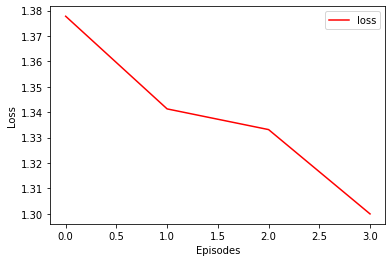

In [24]:
#plot loss
import matplotlib.pyplot as plt
plt.plot(index,loss_result, '-', label='loss', color='red')
plt.xlabel("Episodes")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss.png")
plt.show()

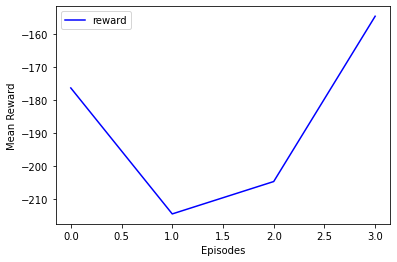

In [25]:
#plot reward and point at which agent is successful
plt.plot(index,mean_reward_result, '-', label='reward', color='blue')
plt.xlabel("Episodes")
plt.ylabel("Mean Reward")
plt.legend()
plt.savefig("reward.png")
plt.show()


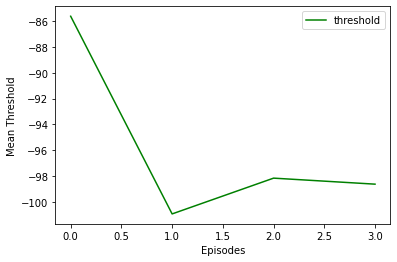

In [26]:
#plot threshold
plt.plot(index,reward_threshold_result, '-', label='threshold', color='green')
plt.xlabel("Episodes")
plt.ylabel("Mean Threshold")
plt.legend()
plt.savefig("threshold.png")
plt.show()

# Save our model

In [27]:
# save the model
torch.save(net, 'model_best.pth.tar')